
# Dane projektowe
---

  * Problem: Klasyfikacja (binarna) zdjęć RTG płuc osób zdrowych i chorych na zapalenie płuc
  * Dane:
    * Źródło: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
    * Rodzaj danych: zdjęcia w formacie jpeg
    * Ilość punktów danych w całej bazie: 3765 (ograniczona do 1254)
    * Struktura: dane podzielone na zbiory uczący i walidacyjny oraz oznaczone etykietami chory/zdrowy
  * Wykorzystane metody:
    * Konwulencyjna sieć neuronowa CNN
    * Metoda wektorów nośnych SVM
    * Regresja logistyczna



# Import potrzebnych bibliotek
---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import shutil
import glob
import matplotlib.image as mpimg

from PIL import Image
import itertools

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

import seaborn as sns
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

import sklearn

# Wizualizacja przykładowych danych w bazie
---

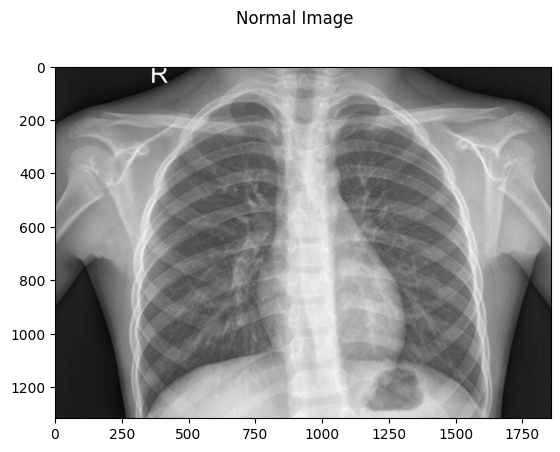

In [135]:
# przypisanie ścieżki dostępu
dataset = "archive/chest_xray/train"

# zdjęcie osoby zdrowej
normal_images = []
for img_path in glob.glob(dataset + '/NORMAL/*'):
    normal_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('Normal Image')
plt.imshow(normal_images[0], cmap='gray')

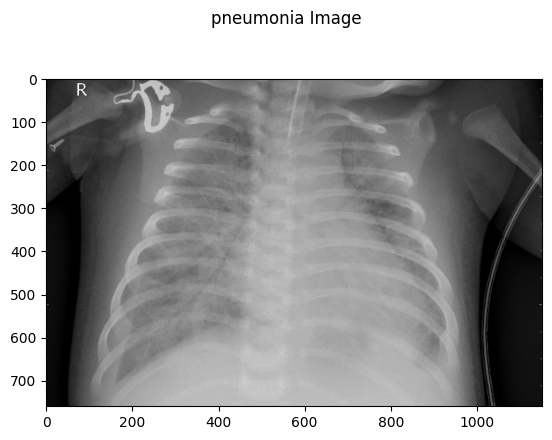

In [136]:
# zdjęcie osoby chorej

pneumonia_images = []
for img_path in glob.glob(dataset + '/PNEUMONIA/*'):
    pneumonia_images.append(mpimg.imread(img_path))

fig = plt.figure()
fig.suptitle('pneumonia Image')
plt.imshow(pneumonia_images[0], cmap='gray')

Po wizualizacji danych widać, że obrazy nie mają ustandaryzowanych wymiarów (zostało to zmienione w dalszej części kodu)

# Pobranie danych ze zbiorów testowego i walidacyjnego
---

In [3]:
# określenie ścieżek plików
FILE_PATH_TRAIN = "archive/chest_xray/train"
NORMAL_FILE_PATH_TRAIN = "archive/chest_xray/train/NORMAL" # normal etykieta: 0
PNEUMONIA_FILE_PATH_TRAIN = "archive/chest_xray/train/PNEUMONIA" # pneumonia etykieta: 1

FILE_PATH_VAL = "archive/chest_xray/val"
NORMAL_FILE_PATH_VAL = "archive/chest_xray/val/NORMAL"
PNEUMONIA_FILE_PATH_VAL = "archive/chest_xray/val/PNEUMONIA"

# sprawdzenie ilości danych oraz ilość danych dla każdej
file_count_train_normal = len([name for name in os.listdir(NORMAL_FILE_PATH_TRAIN) if os.path.isfile(os.path.join(NORMAL_FILE_PATH_TRAIN, name))])
file_count_train_pneumonia = len([name for name in os.listdir(PNEUMONIA_FILE_PATH_TRAIN) if os.path.isfile(os.path.join(PNEUMONIA_FILE_PATH_TRAIN, name))])
file_count_train = file_count_train_normal + file_count_train_pneumonia

file_count_val_normal = len([name for name in os.listdir(NORMAL_FILE_PATH_VAL) if os.path.isfile(os.path.join(NORMAL_FILE_PATH_VAL, name))])
file_count_val_pneumonia = len([name for name in os.listdir(PNEUMONIA_FILE_PATH_VAL) if os.path.isfile(os.path.join(PNEUMONIA_FILE_PATH_VAL, name))])
file_count_val = file_count_val_normal + file_count_val_pneumonia

print("Liczba danych w zbiorze uczącym:", file_count_train)
print("Liczba danych w zbiorze uczącym, etykieta 0:", file_count_train_normal)
print("Liczba danych w zbiorze uczącym, etykieta 1:", file_count_train_pneumonia)

print("Liczba danych w zbiorze walidacyjnym:", file_count_val)
print("Liczba danych w zbiorze walidacyjnym, etykieta 0:", file_count_val_normal)
print("Liczba danych w zbiorze walidacyjnym, etykieta 1:", file_count_val_pneumonia)



Liczba danych w zbiorze uczącym: 4183
Liczba danych w zbiorze uczącym, etykieta 0: 418
Liczba danych w zbiorze uczącym, etykieta 1: 3765
Liczba danych w zbiorze walidacyjnym: 1016
Liczba danych w zbiorze walidacyjnym, etykieta 0: 508
Liczba danych w zbiorze walidacyjnym, etykieta 1: 508


Po wyliczeniu ilosci plików przypisanych w zbiorach dla każdej etykiety widać, że w zbiorze uczącym jest dysproporcja danych w etykietach (dla etykiety 1 ilość zdjęć zostanie ograniczona do 418)

In [4]:
# DANE UCZĄCE

# pobranie listy ścieżek do plików dla dwóch klas
image_names_normal_train = os.listdir(NORMAL_FILE_PATH_TRAIN) # funkcja listdir() tworzy listę ścieżek do plików w określonym folderze
image_names_pneumonia_train = os.listdir(PNEUMONIA_FILE_PATH_TRAIN)

# wybranie losowych obrazów dla obu klas
num_images = 418 # ilość zdjęć dla każdej etykiety w zbiorze uczącym

selected_normal_files_train = random.sample(image_names_normal_train, num_images) # randomizacja wybranych zdjęć
selected_pneumonia_files_train = random.sample(image_names_pneumonia_train, num_images)

# utworzenie pełnych ścieżek do wybranych plików
selected_files_train = [os.path.join(NORMAL_FILE_PATH_TRAIN, filename) for filename in selected_normal_files_train]
selected_files_train.extend([os.path.join(PNEUMONIA_FILE_PATH_TRAIN, filename) for filename in selected_pneumonia_files_train])

# parametry konwersji obrazu
batch_size = 16
MAX_SIDE_LEN = 500
image_size = (MAX_SIDE_LEN, MAX_SIDE_LEN)
datagen = tf.keras.preprocessing.image.ImageDataGenerator() # zdefiniowanie generatora danych

# zamiana wartości liczbowych etykiet na obiekt string (na potrzeby metody DataFrame)
labels_train = np.repeat(np.array(['0', '1']), num_images).reshape(-1,)

# utworzenie DataFrame zawierającym ścieżki do plików i odpowiadające im etykiety
df_train = pd.DataFrame({"filepaths": selected_files_train, "labels": labels_train})

# stworzenie generatora danych na podstawie DataFrame
dataset_train = datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = "filepaths",                    # kolumna zawierająca ścieżki do plików
    y_col = "labels",                       # kolumna zawierająca etykiety
    target_size = image_size,               # docelowy rozmiar obrazów
    batch_size = batch_size,                # rozmiar wsadu (batch_size)
    class_mode = 'binary',                  # tryb klasy (binary dla problemu binarnego)
    shuffle = True,                         # mieszanie danych
    color_mode = 'grayscale'                # tryb koloru (grayscale dla obrazów w skali szarości)
)

#DANE WALIDACYJNE

# pobranie listy ścieżek do  plików dla dwóch klas
image_names_normal_val = os.listdir(NORMAL_FILE_PATH_VAL) # funkcja listdir() tworzy listę ścieżek do plików w określonym folderze
image_names_pneumonia_val = os.listdir(PNEUMONIA_FILE_PATH_VAL)

selected_normal_files_val = random.sample(image_names_normal_val, num_images//2) # randomizacja wybranych zdjęć
selected_pneumonia_files_val = random.sample(image_names_pneumonia_val, num_images//2)

# utworzenie pełnych ścieżek do wybranych plików
selected_files_val = [os.path.join(NORMAL_FILE_PATH_VAL, filename) for filename in selected_normal_files_val]
selected_files_val.extend([os.path.join(PNEUMONIA_FILE_PATH_VAL, filename) for filename in selected_pneumonia_files_val])

# zamiana wartości liczbowych etykiet na obiekt string (na potrzeby metody DataFrame)
labels_val = np.repeat(np.array(['0', '1']), num_images//2).reshape(-1,)

# utworzenie DataFrame zawierającym ścieżki do plików i odpowiadające im etykiety
df_val = pd.DataFrame({"filepaths": selected_files_val, "labels": labels_val})


# stworzenie generatora danych na podstawie DataFrame
dataset_val = datagen.flow_from_dataframe(
    dataframe = df_val,
    x_col = "filepaths",                      # kolumna zawierająca ścieżki do plików
    y_col = "labels",                         # kolumna zawierająca etykiety
    target_size = (500, 500),                 # docelowy rozmiar obrazów
    batch_size = batch_size,                  # rozmiar wsadu (batch_size)
    class_mode = 'binary',                    # tryb klasy (binary dla problemu binarnego)
    shuffle = True,                           # mieszanie danych
    color_mode = 'grayscale'                  # tryb koloru (grayscale dla obrazów w skali szarości)
)

Found 836 validated image filenames belonging to 2 classes.


Found 418 validated image filenames belonging to 2 classes.


# Sprawdzenie poprawności przekształcenia zbioru danych
---

In [5]:
# PODSUMOWANIE INFORMACJI O ZBIORZE DANYCH

# DANE UCZĄCE
# pobranie listy ścieżek plików
file_paths_train = dataset_train.filepaths

# pobranie listy etykiet
labels_train = dataset_train.labels

# pobranie słownika przypisania etykiety do indeksu
class_indices_train = dataset_train.class_indices

# obliczenie liczby rekordów
num_records_train = len(file_paths_train)

# sprawdzenie unikalnych etykiet
unique_labels_train = np.unique(labels_train)

# utworzenie zmiennej do przechowywania liczby danych przypisanych do każdej etykiety
label_counts_train = {label: np.sum(labels_train == label) for label in unique_labels_train}

# wyświetlenie informacji
print("Liczba rekordów w zbiorze uczącym:", num_records_train)
print("Liczba kolumn w zbiorze uczącym:", dataset_train.image_shape) # image_shape - wymiar obrazu i ilość kanałów (RGB - 3; grayscale - 1)
print("Unikalne etykiety w zbiorze uczącym:", unique_labels_train)
print("Liczba danych uczących przypisanych do każdej etykiety:")
for label, count in label_counts_train.items():
    print(f"Etykieta {label}: {count} danych")

# procentowy rozkład danych w etykietach
procent_0_normal_train = np.sum(np.array(labels_train) == 0)/num_records_train*100
procent_1_normal_train = np.sum(np.array(labels_train) == 1)/num_records_train*100

print("Ilość procentowa danych w zbiorze uczącym o: etykiecie 0 -", procent_0_normal_train, "%", ", etykiecie 1 -", procent_1_normal_train, "%")

# DANE WALIDACYJNE
# pobranie listy ścieżek plików
file_paths_val = dataset_val.filepaths

# pobranie listy etykiet
labels_val = dataset_val.labels

# pobranie słownika przypisania etykiety do indeksu
class_indices_val = dataset_val.class_indices

# obliczenie liczby rekordów
num_records_val = len(file_paths_val)

# sprawdzenie unikalnych etykiet
unique_labels_val = np.unique(labels_val)

# utworzenie zmiennej do przechowywania liczby danych przypisanych do każdej etykiety
label_counts_val = {label: np.sum(labels_val == label) for label in unique_labels_val}

# wyświetlenie informacji
print("Liczba rekordów w zbiorze walidacyjnym:", num_records_val)
print("Liczba kolumn w zbiorze walidacyjnym:", dataset_val.image_shape) # image_shape - wymiar obrazu i ilość kanałów (RGB - 3; grayscale - 1)
print("Unikalne etykiety w zbiorze walidacyjnym:", unique_labels_val)
print("Liczba danych w zbiorze walidacyjnym przypisanych do każdej etykiety:")
for label, count in label_counts_val.items():
    print(f"Etykieta {label}: {count} danych")

# procentowy rozkład danych w etykietach
procent_0_normal_val = np.sum(np.array(labels_val) == 0)/num_records_val*100
procent_1_normal_val = np.sum(np.array(labels_val) == 1)/num_records_val*100

print("Ilość procentowa danych w zbiorze treningowym o: etykiecie 0 -", procent_0_normal_val, "%", ", etykiecie 1 -", procent_1_normal_val, "%")
print("Słownik etykiet walidacyjnych: ", class_indices_train, ";Słownik etykiet walidacyjnych: ", class_indices_val)

Liczba rekordów w zbiorze uczącym: 836
Liczba kolumn w zbiorze uczącym: (500, 500, 1)
Unikalne etykiety w zbiorze uczącym: [0 1]
Liczba danych uczących przypisanych do każdej etykiety:
Etykieta 0: 418 danych
Etykieta 1: 418 danych
Ilość procentowa danych w zbiorze uczącym o: etykiecie 0 - 50.0 % , etykiecie 1 - 50.0 %
Liczba rekordów w zbiorze walidacyjnym: 418
Liczba kolumn w zbiorze walidacyjnym: (500, 500, 1)
Unikalne etykiety w zbiorze walidacyjnym: [0 1]
Liczba danych w zbiorze walidacyjnym przypisanych do każdej etykiety:
Etykieta 0: 209 danych
Etykieta 1: 209 danych
Ilość procentowa danych w zbiorze treningowym o: etykiecie 0 - 50.0 % , etykiecie 1 - 50.0 %
Słownik etykiet walidacyjnych:  {'0': 0, '1': 1} ;Słownik etykiet walidacyjnych:  {'0': 0, '1': 1}


In [10]:
for image_batch, label_batch in dataset_train:
    print(image_batch)
    print(label_batch)
    break  # Przerwij pętlę po pobraniu jednej partii danych

for image_batch, label_batch in dataset_val:
    print(image_batch)
    print(label_batch)
    break  # Przerwij pętlę po pobraniu jednej partii danych

[[[[  0.]
   [  0.]
   [  0.]
   ...
   [ 16.]
   [ 16.]
   [ 15.]]

  [[  0.]
   [  0.]
   [  0.]
   ...
   [ 15.]
   [ 16.]
   [ 13.]]

  [[  0.]
   [  0.]
   [  0.]
   ...
   [ 14.]
   [ 16.]
   [ 16.]]

  ...

  [[ 12.]
   [ 14.]
   [ 12.]
   ...
   [ 12.]
   [ 11.]
   [ 14.]]

  [[ 13.]
   [ 13.]
   [ 12.]
   ...
   [ 12.]
   [ 11.]
   [ 13.]]

  [[ 14.]
   [ 13.]
   [ 12.]
   ...
   [ 12.]
   [ 11.]
   [ 12.]]]


 [[[148.]
   [152.]
   [145.]
   ...
   [108.]
   [116.]
   [120.]]

  [[145.]
   [151.]
   [144.]
   ...
   [111.]
   [119.]
   [120.]]

  [[146.]
   [152.]
   [144.]
   ...
   [113.]
   [121.]
   [119.]]

  ...

  [[186.]
   [179.]
   [180.]
   ...
   [ 84.]
   [ 74.]
   [ 63.]]

  [[186.]
   [179.]
   [179.]
   ...
   [ 85.]
   [ 75.]
   [ 61.]]

  [[187.]
   [179.]
   [179.]
   ...
   [ 88.]
   [ 77.]
   [ 66.]]]


 [[[208.]
   [214.]
   [207.]
   ...
   [ 13.]
   [  2.]
   [  0.]]

  [[213.]
   [216.]
   [210.]
   ...
   [ 12.]
   [ 10.]
   [  1.]]

  [[212.]
   [21

Dane zostały prawidłowo przetworzone, wylosowanie danych o etykiecie 0 lub 1 w próbie ma prawdopodobieństwo 50%

# Definicja modelu sieci neuronowej CNN
---
*model przed tunningiem*

In [141]:
# zdefiniowano checkpoint dla modeli sieci neuronowych w celu przyspieszenia obliczeń
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model_weights.keras', save_best_only=True)

In [142]:
random.seed(0)
model1 = models.Sequential()
model1.add(layers.Rescaling(1//255)) # próba zmainy z wartości (1./255)

# dodanie warstw konwolucyjnych
model1.add(layers.Conv2D(128, (3, 3), activation= 'relu', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN, 1]))
 # użyto 128 różnych filtrów, rozmiaru ramki 3x3 i funkcji aktywacji RELU
model1.add(layers.MaxPooling2D(2, 2)) # standardowe parametry

# dodanie kolejnej warstwy konwolucyjnej
model1.add(layers.Conv2D(64, (3, 3), activation= 'relu')) # dla następnych elementów nie trzeba określać input_shape
model1.add(layers.MaxPooling2D(2, 2))

# dodanie kolejnej warstwy konwolucyjnej
model1.add(layers.Flatten()) # przejście z warstw konwolucyjnej do warstwy łączącej
# warstwa całkowicie połączona
model1.add(layers.Dense (128, activation='relu')) # każdy input idzie do każdego węzła
model1.add(layers.Dense(1)) # ponieważ wynik jest binarny w warstwie wyjścia potrzebny jest tylko jeden węzeł

# Etap uczenia sieci
---
*   kompilacja modelu
*   parametry iteracji
*   trening





In [143]:
lr = 0.0001 # learning rate
model1.compile(optimizer=tf.keras.optimizers.Adam(lr),  # kompilacja modelu, użyty popularny kompilator Adam
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [144]:
epochs = 5
# Liczba kroków na epokę (każdy krok obejmuje batch_size przykładów)
steps_per_epoch = len(dataset_train)

# Liczba kroków na walidację
validation_steps = len(dataset_val)

history = model1.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1 # pokazuje wydruk
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - accuracy: 0.4977 - loss: 0.6932 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 26s 484ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.5141 - loss: 0.6931 - val_accuracy: 0.5162 - val_loss: 0.6931
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 25s 480ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 301s 6s/step - accuracy: 0.5197 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


Ponieważ co w co drugiej epoce dokładność modelu spada do 0 zbadano parametry modelu

In [145]:
# sprawdzenie poprawności modelu

# Sprawdzenie danych treningowych
print("Przykładowe ścieżki plików z danych treningowych:")
for filepath, label in zip(selected_files_train[:5], labels_train[:5]):
    print("Ścieżka:", filepath, "Etykieta:", label)

# Sprawdzenie danych walidacyjnych
print("\nPrzykładowe ścieżki plików z danych walidacyjnych:")
for filepath, label in zip(selected_files_val[:5], labels_val[:5]):
    print("Ścieżka:", filepath, "Etykieta:", label)

# Sprawdzenie architektury modelu
print("\nArchitektura modelu:")
model1.summary()

# Sprawdzenie liczby parametrów modelu
print("\nLiczba parametrów modelu:", model1.count_params())

# Sprawdzenie hiperparametrów
print("\nHiperparametry modelu:")
print("Współczynnik uczenia się (learning rate):", lr)
print("Rozmiar wsadu (batch size):", batch_size)

# Sprawdzenie ilości dostępnych kroków na epokę i walidację
print("\nLiczba kroków na epokę:", steps_per_epoch)
print("Liczba kroków na walidację:", validation_steps)


Przykładowe ścieżki plików z danych treningowych:
Ścieżka: archive/chest_xray/train/NORMAL\NORMAL2-IM-0086-0001 — kopia.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/train/NORMAL\IM-0003-0001 — kopia.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/train/NORMAL\IM-0023-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/train/NORMAL\IM-0079-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/train/NORMAL\NORMAL2-IM-0348-0001.jpeg Etykieta: 0

Przykładowe ścieżki plików z danych walidacyjnych:
Ścieżka: archive/chest_xray/val/NORMAL\NORMAL2-IM-1132-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/val/NORMAL\NORMAL2-IM-0687-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/val/NORMAL\NORMAL2-IM-0669-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/val/NORMAL\NORMAL2-IM-0403-0001.jpeg Etykieta: 0
Ścieżka: archive/chest_xray/val/NORMAL\IM-0386-0001.jpeg Etykieta: 0

Architektura modelu:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ rescaling_16 (Rescaling)        │ (None, 500, 500, 1)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_46 (Conv2D)              │ (None, 498, 498, 128)     │      1,280 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 249, 249, 128)     │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_47 (Conv2D)              │ (None, 247, 247, 64)      │     73,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 123, 123, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_19 (Flatten)            │ (None, 968256)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_38 (Dense)                │ (None, 128)               │ 123,936,8… │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_39 (Dense)                │ (None, 1)                 │        129 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 372,036,293 (1.39 GB)

 Trainable params: 124,012,097 (473.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 248,024,196 (946.14 MB)


Liczba parametrów modelu: 124012097

Hiperparametry modelu:
Współczynnik uczenia się (learning rate): 0.0001
Rozmiar wsadu (batch size): 16

Liczba kroków na epokę: 53
Liczba kroków na walidację: 27


# Tuning sieci
---

### Wprowadzone zmiany w kolejnym modelu:
* zmniejszenie współczynnika uczenia
* wprowadzenie warstw drop out
* zmiana optymalizatora z Adam na SGD
* zmiana ze zmniejszającej się ilości filtrów w warstwach konwolucyjnych na zwiększającą się ilość filtrów

In [156]:
random.seed(0)
model1n = models.Sequential()
model1n.add(layers.Rescaling(1./255))

# dodanie warstw konwolucyjnych
model1n.add(layers.Conv2D(64, (3, 3), activation= 'relu', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN, 1]))
 # użyto 64 różnych filtrów, rozmiaru ramki 3x3 i funkcji aktywacji RELU
model1n.add(layers.Dropout(0.25))
model1n.add(layers.MaxPooling2D(2, 2)) # standardowe parametry
model1n.add(layers.Dropout(0.25))

# dodanie kolejnej warstwy konwolucyjnej
model1n.add(layers.Conv2D(128, (3, 3), activation= 'relu')) # dla następnych elementów nie trzeba określać input_shape
model1n.add(layers.Dropout(0.25))
model1n.add(layers.MaxPooling2D(2, 2))
model1n.add(layers.Dropout(0.25))

# dodanie kolejnej warstwy konwolucyjnej
model1n.add(layers.Flatten()) # przejście z warstw konwolucyjnej do warstwy łączącej
# warstwa całkowicie połączona
model1n.add(layers.Dense (128, activation='relu')) # każdy input idzie do każdego węzła
model1n.add(layers.Dense(1)) # ponieważ wynik jest binarny w warstwie wyjścia potrzebny jest tylko jeden węzeł

lr = 0.00001 # zmniejszenie współczynnika uczenia
model1n.compile(optimizer=tf.keras.optimizers.SGD(lr), #zmiana optymalizatora
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

epochs = 5
# Liczba kroków na epokę (każdy krok obejmuje batch_size przykładów)
steps_per_epoch = len(dataset_train)

# Liczba kroków na walidację
validation_steps = len(dataset_val)

history1n = model1n.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 388s 7s/step - accuracy: 0.4875 - loss: 0.6928 - val_accuracy: 0.5162 - val_loss: 0.6913
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 417ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6911
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 365s 7s/step - accuracy: 0.5015 - loss: 0.6878 - val_accuracy: 0.5000 - val_loss: 0.6892
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 22s 409ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 0.6899
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 359s 7s/step - accuracy: 0.5025 - loss: 0.6838 - val_accuracy: 0.5000 - val_loss: 0.6880


In [157]:
# porównanie modleu z modelem 1
model1_accuracy = history.history['val_accuracy']
print("Dokładność walidacji: ", model1_accuracy)
model1_accuracy = np.median(model1_accuracy)
print("Mediana dokładności walidacji: ", model1_accuracy)

model1n_accuracy = history1n.history['val_accuracy']
print("Dokładność walidacji po modyfikacji: ", model1n_accuracy)
model1n_accuracy = np.median(model1n_accuracy)
print("Mediana dokładności walidacji: ", model1n_accuracy)

porownanie_accuracy0 = model1n_accuracy - model1_accuracy

print(f"Zmiana w dokładności między modelem1 i modelem1n: {porownanie_accuracy0}")

Dokładność walidacji:  [0.5162037014961243, 0.5162037014961243, 0.5162037014961243, 0.5, 0.5]
Mediana dokładności walidacji:  0.5162037014961243
Dokładność walidacji po modyfikacji:  [0.5162037014961243, 0.5, 0.5, 0.5162037014961243, 0.5]
Mediana dokładności walidacji:  0.5
Zmiana w dokładności między modelem1 i modelem1n: -0.016203701496124268


<b><u>Dokładnosć modelu spadła o 1,6%</u></b>

### Wprowadzone zmiany w kolejnym modelu:
* wprowadzenie warstw drop out
* wprowadzenie warstwy, której zadaniem jest losowe przekształcenie przestrzenne obrazu

In [158]:
# modyfikacja przestrzenna obrazów
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
])

In [149]:
# pobranie jednej partii danych
images, labels = next(dataset_train)

# wykonanie operacji na wszystkich obrazach
for i in range(len(images)):
    image = images[i]
    image = tf.cast(tf.expand_dims(image, 0), tf.float32)  # zwiększenie wymiarów - stworzenie listy, w której jest tylko jeden obraz

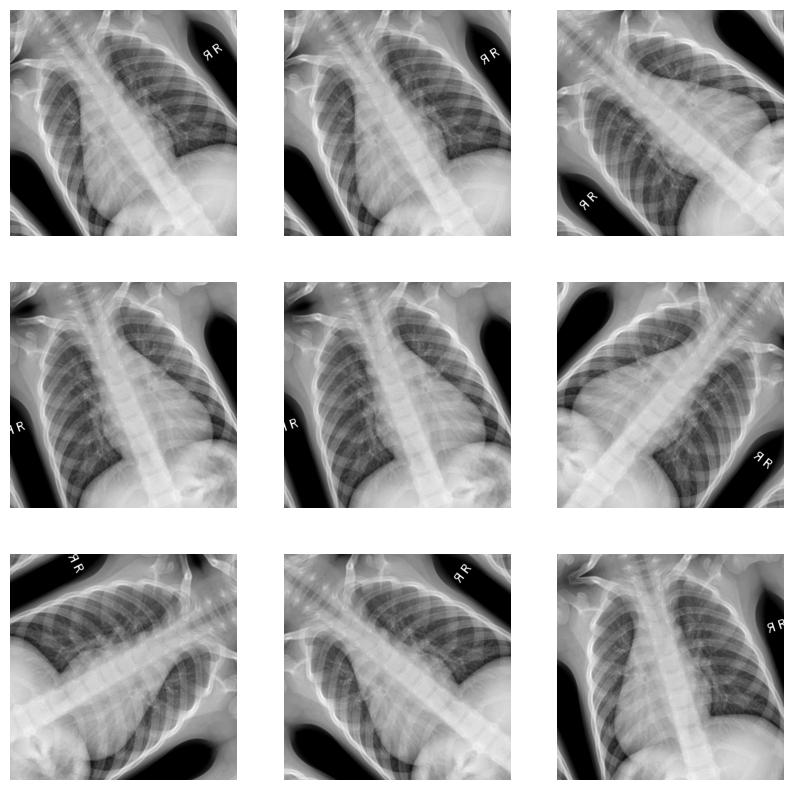

In [150]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_image[0], cmap='gray')
  plt.axis("off")

In [159]:
random.seed(0)
model2 = models.Sequential()
model2.add(layers.Rescaling(1./255)) # zmiana skali kolorów dla każdego piksela teraz do opisu kolorów nie używamy skali 0-255 tylko 0-1

#warstwa manipulacji przestrzennej obrazu
model2.add(data_augmentation)

# dodanie warstw konwolucyjnych
model2.add(layers.Conv2D(32, (3, 3), activation= 'relu', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN, 1])) # w input_shape cyfra 3 oznacza kolorowe obrazy
 # użyto 128 różnych filtrów, rozmiaru ramki 3x3 i funkcji aktywacji RELU
model2.add(layers.Dropout(0.25))
model2.add(layers.MaxPooling2D(2, 2)) # standardowe parametry
model2.add(layers.Dropout(0.25))
model2.add(layers.Dropout(0.25)) # w trakcie uczenia będzie wyłączane przypadkowo 25% połączeń

# dodanie kolejnej warstwy konwolucyjnej
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(64, (3, 3), activation= 'relu')) # dla następnych elementów nie trzeba określać input_shape
# w warstwie konwolucyjnej można dodać parametr regularyzacji, który ogranicza jak mocno mogą zmieniać się wagi współczynników
# na końcu dodać kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
model2.add(layers.Dropout(0.25))
model2.add(layers.MaxPooling2D(2, 2))
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv2D(32, (3, 3), activation= 'relu'))
model2.add(layers.Dropout(0.25))
model2.add(layers.MaxPooling2D(2, 2))

model2.add(layers.Dropout(0.25))
model2.add(layers.Flatten()) # przejście z warstw konwolucyjnej do warstwy łączącej
# warstwa całkowicie połączona
model2.add(layers.Dense (128, activation='relu')) # każdy input idzie do każdego węzła
model2.add(layers.Dense(1)) # ponieważ wynik jest binarny w warstwie wyjścia potrzebny jest tylko jeden węzeł

In [160]:
lr = 0.0001 # learning rate
model2.compile(optimizer=tf.keras.optimizers.Adam(lr),  # kompilacja modelu, użyty popularny kompilator
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [161]:
epochs = 5
history2 = model2.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.5422 - loss: 0.8204 - val_accuracy: 0.5162 - val_loss: 0.6776
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6780
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.6674 - loss: 0.6039 - val_accuracy: 0.5162 - val_loss: 0.6742
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6749
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.7108 - loss: 0.5459 - val_accuracy: 0.4838 - val_loss: 0.6784


In [162]:
# porównanie modleu z modelem 1
model2_accuracy = history2.history['val_accuracy']
print("Dokładność: ", model2_accuracy)
model2_accuracy = np.median(model2_accuracy)
print("Mediana dokładności: ", model2_accuracy)

porownanie_accuracy1 = model2_accuracy - model1_accuracy
print("Różnica dokładności nowego i starego modelu: ", porownanie_accuracy1)

Dokładność:  [0.5162037014961243, 0.5, 0.5162037014961243, 0.5, 0.48379629850387573]
Mediana dokładności:  0.5
Różnica dokładności nowego i starego modelu:  -0.016203701496124268


<b><u>Dokładność modelu spadła o ok 1,6%</u></b>

### Wprowadzone zmiany w kolejnym modelu
---
* zmiana funkcji aktywacji z funkcji RELU na funkcję sigmoid
* wprowadzono regularyzator L2

In [163]:
random.seed(0)
model3 = models.Sequential()
model3.add(layers.Rescaling(1./255)) # zmiana skali kolorów dla każdego piksela teraz do opisu kolorów nie używamy skali 0-255 tylko 0-1

#warstwa manipulacji przestrzennej obrazu
model3.add(data_augmentation)

# dodanie warstw konwolucyjnych
model3.add(layers.Conv2D(128, (3, 3), activation= 'sigmoid', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN, 1]))
 # użyto 128 różnych filtrów, rozmiaru ramki 3x3 i funkcji aktywacji sigmoid
model3.add(layers.MaxPooling2D(2, 2)) # standardowe parametry
model3.add(layers.Dropout(0.25)) # w trakcie uczenia będzie wyłączane przypadkowo 25% połączeń

# dodanie kolejnej warstwy konwolucyjnej
model3.add(layers.Conv2D(64, (3, 3), activation= 'sigmoid')) # dla następnych elementów nie trzeba określać input_shape
# w warstwie konwolucyjnej można dodać parametr regularyzacji, który ogranicza jak mocno mogą zmieniać się wagi współczynników
# na końcu dodać kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
model3.add(layers.MaxPooling2D(2, 2))
model3.add(layers.Dropout(0.25))

# dodanie kolejnej warstwy konwolucyjnej
model3.add(layers.Dropout(0.25))
model3.add(layers.Flatten()) # przejście z warstw konwolucyjnej do warstwy łączącej
# warstwa całkowicie połączona
model3.add(layers.Dense (128, activation='sigmoid')) # każdy input idzie do każdego węzła
model3.add(layers.Dense(1)) # ponieważ wynik jest binarny w warstwie wyjścia potrzebny jest tylko jeden węzeł
kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [164]:
lr = 0.0001 # learning rate
model3.compile(optimizer=tf.keras.optimizers.Adam(lr),  # kompilacja modelu, użyty popularny kompilator
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [165]:
epochs = 5
history3 = model3.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/5


53/53 ━━━━━━━━━━━━━━━━━━━━ 394s 7s/step - accuracy: 0.5064 - loss: 2.6290 - val_accuracy: 0.5000 - val_loss: 2.7547
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 554ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4838 - val_loss: 2.8439
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.5007 - loss: 2.7116 - val_accuracy: 0.5000 - val_loss: 2.5988
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 29s 543ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 2.5148
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.4804 - loss: 2.6610 - val_accuracy: 0.5162 - val_loss: 2.3652


In [166]:
# porównanie modleu z modelem 1
model3_accuracy = history3.history['val_accuracy']
print("Dokładność: ", model3_accuracy)
model3_accuracy = np.median(model3_accuracy)
print("Mediana dokładności: ", model3_accuracy)

porownanie_accuracy3 = model3_accuracy - model1_accuracy
print("Różnica dokładności modelu z funkcją relu i sigmoid: ", porownanie_accuracy3)

Dokładność:  [0.5, 0.48379629850387573, 0.5, 0.5162037014961243, 0.5162037014961243]
Mediana dokładności:  0.5
Różnica dokładności modelu z funkcją relu i sigmoid:  -0.016203701496124268


<b><u>Dokładność modelu spadła o ok. 1,6%</u></b>

### Wprowadzone zmiany w kolejnym modelu
---
* zmiana funkcji aktywacji z funkcji RELU na funkcję sigmoid
* wprowadzono regularyzator L2
* zwiększenie wskaźnika learning ratio z lr = 0.0001 na lr_n = 0.0017

In [167]:
lr_n = 0.0017 # learning rate

random.seed(0)
model4 = models.Sequential()
model4.add(layers.Rescaling(1./255)) # zmiana skali kolorów dla każdego piksela teraz do opisu kolorów nie używamy skali 0-255 tylko 0-1

#warstwa manipulacji przestrzennej obrazu
model4.add(data_augmentation)

# dodanie warstw konwolucyjnych
model4.add(layers.Conv2D(128, (3, 3), activation= 'sigmoid', input_shape=[MAX_SIDE_LEN,MAX_SIDE_LEN, 1])) # w input_shape cyfra 3 oznacza kolorowe obrazy
 # użyto 128 różnych filtrów, rozmiaru ramki 3x3 i funkcji aktywacji sigmoid
model4.add(layers.MaxPooling2D(2, 2)) # standardowe parametry
model4.add(layers.Dropout(0.25)) # w trakcie uczenia będzie wyłączane przypadkowo 25% połączeń

# dodanie kolejnej warstwy konwolucyjnej
model4.add(layers.Conv2D(64, (3, 3), activation= 'sigmoid')) # dla następnych elementów nie trzeba określać input_shape
# w warstwie konwolucyjnej można dodać parametr regularyzacji, który ogranicza jak mocno mogą zmieniać się wagi współczynników
# na końcu dodać kernel_regularizer=tf.keras.regularizers.l2(l=0.01)
model4.add(layers.MaxPooling2D(2, 2))
model4.add(layers.Dropout(0.25))

# dodanie kolejnej warstwy konwolucyjnej
model4.add(layers.Dropout(0.25))
model4.add(layers.Flatten()) # przejście z warstw konwolucyjnej do warstwy łączącej
# warstwa całkowicie połączona
model4.add(layers.Dense (128, activation='sigmoid')) # każdy input idzie do każdego węzła
model4.add(layers.Dense(1)) # ponieważ wynik jest binarny w warstwie wyjścia potrzebny jest tylko jeden węzeł

model4.compile(optimizer=tf.keras.optimizers.Adam(lr_n),  # kompilacja modelu, użyty popularny kompilator
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

kernel_regularizer=tf.keras.regularizers.l2(0.01)

In [168]:
epochs = 5
history4 = model4.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 396s 7s/step - accuracy: 0.4927 - loss: 2.2951 - val_accuracy: 0.5000 - val_loss: 0.8310
Epoch 2/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 532ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 0.8136
Epoch 3/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 367s 7s/step - accuracy: 0.5244 - loss: 0.7095 - val_accuracy: 0.4838 - val_loss: 0.6965
Epoch 4/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 28s 526ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 0.6929
Epoch 5/5
53/53 ━━━━━━━━━━━━━━━━━━━━ 371s 7s/step - accuracy: 0.4795 - loss: 0.6949 - val_accuracy: 0.4838 - val_loss: 0.6936


In [169]:
# porównanie modleu z modelem 1
model4_accuracy = history4.history['val_accuracy']
print("Dokładność: ", model4_accuracy)
model4_accuracy = np.median(model4_accuracy)
print("Mediana dokładności: ", model4_accuracy)

porownanie_accuracy4 = model4_accuracy - model1_accuracy
print("Różnica dokładności modelu z funkcją relu i sigmoid: ", porownanie_accuracy4)

Dokładność:  [0.5, 0.5162037014961243, 0.48379629850387573, 0.5162037014961243, 0.48379629850387573]
Mediana dokładności:  0.5
Różnica dokładności modelu z funkcją relu i sigmoid:  -0.016203701496124268


<b><u>Dokładność modelu spadła o ok. 1,6%</u></b>

### Wprowadzone zmiany w kolejnym modelu
---
* funkcja aktywacji funkcja RELU
* wprowadzenie warst dropout
* wprowadzono regularyzator L2
* zwiększenie wskaźnika learning ratio z lr = 0.0001 na lr_n = 0.0017
* zwiększenie liczby epok do 20

In [170]:
# dane dla modelu:
    # struktrura modelu 2
    # learning ratio: lr_n = 0,0017
    # porównanie z modelem 2

model2.compile(optimizer=tf.keras.optimizers.Adam(lr_n),  # kompilacja modelu, użyty popularny kompilator
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [171]:
epochs = 20
history5 = model2.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val,
    epochs=epochs,
    callbacks=[checkpoint],
    verbose=1 # pokazuje wydruk
)

Epoch 1/20


53/53 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.5131 - loss: 1.1801 - val_accuracy: 0.4838 - val_loss: 0.6934
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4914 - loss: 0.6933 - val_accuracy: 0.5162 - val_loss: 0.6932
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5162 - val_loss: 0.6932
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.4978 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.4994 - loss: 0.6932 - val_accuracy: 0.4838 - val_loss: 0.6932
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 -

In [175]:
# porównanie modleu z modelem 1
model5_accuracy = history5.history['val_accuracy']
print("Dokładność: ", model5_accuracy)
model5_accuracy = np.median(model5_accuracy)
print("Mediana dokładności: ", model5_accuracy)

porownanie_accuracy5 = model5_accuracy - model1_accuracy
print(model2_accuracy)
print("Różnica dokładności modelu z mniejszą i większą ilością kroków na epokę: ", porownanie_accuracy5)

Dokładność:  [0.48379629850387573, 0.5, 0.5162037014961243, 0.5162037014961243, 0.5, 0.5, 0.48379629850387573, 0.5, 0.48379629850387573, 0.5, 0.5, 0.48379629850387573, 0.5162037014961243, 0.5, 0.48379629850387573, 0.5162037014961243, 0.48379629850387573, 0.5162037014961243, 0.48379629850387573, 0.5162037014961243]
Mediana dokładności:  0.5
0.5
Różnica dokładności modelu z mniejszą i większą ilością kroków na epokę:  -0.016203701496124268


<b><u>Dokładność modelu spadła o ok. 1,6%</u></b>

# Podsumowanie 5 modeli sieci CNN
---

In [176]:
print("Dokładność modelu 1: ", model1_accuracy)
print("Dokładność modelu 1n: ", model1n_accuracy)
print("Dokładność modelu 2: ", model2_accuracy)
print("Dokładność modelu 3: ", model3_accuracy)
print("Dokładność modelu 4: ", model4_accuracy)
print("Dokładność modelu 5: ", model5_accuracy)

Dokładność modelu 1:  0.5162037014961243
Dokładność modelu 1n:  0.5
Dokładność modelu 2:  0.5
Dokładność modelu 3:  0.5
Dokładność modelu 4:  0.5
Dokładność modelu 5:  0.5


In [178]:
print(f"Dokładność modelu 1 (RELU; lr=0,0001; epoch=5): {model1_accuracy}")
print(f"Dokładność modelu 1n (RELU; lr=0,00001; epoch=5): {model1n_accuracy}")
print(f"Dokładność modelu 2 (RELU; lr=0,0001; epoch=5; przekształcenia): {model2_accuracy}")
print(f"Dokładność modelu 3 (SIGMOID; lr=0,0001; epoch=5; przekształcenia): {model3_accuracy}")
print(f"Dokładność modelu 4 (SIGMOID; lr=0,0017; epoch=5; przekształcenia): {model4_accuracy}")
print(f"Dokładność modelu 5 (RELU; lr=0,0001; epoch=20; przekształcenia): {model5_accuracy}")

list_accuracy = [model1_accuracy, model2_accuracy, model3_accuracy, model4_accuracy, model5_accuracy]

max_accuracy = max(list_accuracy)
min_accuracy = min(list_accuracy)

print(f"Model z największą dokładnością: Model 1 ({max_accuracy})")
print(f"Model z najmniejszą dokładnością: Reszta ({min_accuracy})")

Dokładność modelu 1 (RELU; lr=0,0001; epoch=5): 0.5162037014961243
Dokładność modelu 1n (RELU; lr=0,00001; epoch=5): 0.5
Dokładność modelu 2 (RELU; lr=0,0001; epoch=5; przekształcenia): 0.5
Dokładność modelu 3 (SIGMOID; lr=0,0001; epoch=5; przekształcenia): 0.5
Dokładność modelu 4 (SIGMOID; lr=0,0017; epoch=5; przekształcenia): 0.5
Dokładność modelu 5 (RELU; lr=0,0001; epoch=20; przekształcenia): 0.5
Model z największą dokładnością: Model 1 (0.5162037014961243)
Model z najmniejszą dokładnością: Reszta (0.5)


# Metoda maszyny wektorów nośnych (SVM)
---

In [179]:
from sklearn.preprocessing import StandardScaler

X_train, y_train = [], []
X_val, y_val = [], []

# pobranie danych uczących i danych walidacyjnych z dataset_train i dataset_val
for _ in range(len(dataset_train)): # symbol _ oznacza, że nie jest konieczne określenie dokładnej zmiennej jak i (wykorzystana długość bazy danych) 
    X_batch, y_batch = next(dataset_train) # funkcja next() pobiera tylko jedną partię danych (dlatego potrzebna iteracja)
    X_train.extend(X_batch)
    y_train.extend(y_batch)

for _ in range(len(dataset_val)):
    X_batch, y_batch = next(dataset_val)
    X_val.extend(X_batch)
    y_val.extend(y_batch)

# konwersja listy na tablice numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# spłaszczenie danych wejściowych (do metody SVM tablica może mieć tylko 2 kolumny, a miała 3)
X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_val_flattened = X_val.reshape(X_val.shape[0], -1)

# normalizacja danych (do motedy SVM i regresji logistycznej)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_val_scaled = scaler.transform(X_val_flattened)

# przypisanie etykiet (utworzenie wektora)
y_train = df_train['labels']
y_val = df_val['labels']

# utworzenie i dopasowanie klasyfikatora SVM do danych uczących
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train_scaled, y_train)

# przewidywanie etykiet dla danych walidacyjnych
y_pred = clf.predict(X_val_scaled)

# ocena wyników
from sklearn.metrics import accuracy_score

SVM_accuracy = accuracy_score(y_val, y_pred)
print("Dokładność klasyfikacji:", SVM_accuracy)


Dokładność klasyfikacji: 0.5239234449760766


# Model regresji logistycznej
---

In [180]:
from sklearn.linear_model import LogisticRegression

# normalizacja danych 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flattened)
X_val_scaled = scaler.transform(X_val_flattened)

# utworzenie i dopasowanie modelu regresji logistycznej do danych uczących
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# przewidywanie etykiet dla danych walidacyjnych
y_pred = log_reg.predict(X_val_scaled)

# ocena wyników
reg_accuracy = accuracy_score(y_val, y_pred)
print("Dokładność klasyfikacji regresji logistycznej:", reg_accuracy)

Dokładność klasyfikacji regresji logistycznej: 0.5119617224880383


# Porównanie modelu sieci neuronowej CNN, z metodą SVM i regresji logistycznej
---

In [182]:
print(f"Dokładność sieci neuronowej CNN: {model1_accuracy}")
print(f"Dokładność metody SVM: {SVM_accuracy}")
print(f"Dokładność metody regresji logistycznej: {reg_accuracy}")

Dokładność sieci neuronowej CNN: 0.5162037014961243
Dokładność metody SVM: 0.5239234449760766
Dokładność metody regresji logistycznej: 0.5119617224880383


Najlepsza dokładność dla meotdy wektorów nośnych, następnie sieci neuronwej, najgorsza dla regresji logistycznej

Spadek dokładności sieci neuronowej po zmianie przestrzennej obrazów może wynikać z powodu, że sieć neuronowa nie tyle analizuje strukturę płuc u osób zrowych lub chorych, ale czy osoba leżała czy siedziała/stała w trakcie wykonywanego zdjęcia RTG i na tej podstawie kategoryzuje czy osoba była zdrowa czy nie.

# Bibliografia
---
dostępne na dzień 10.02.2024

1. https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
2. https://www.kaggle.com/code/shivan118/x-ray-detecting-using-cnn
3. https://www.tensorflow.org/api_docs/python/tf/data/Dataset
4. https://towardsdatascience.com/how-to-choose-the-optimal-learning-rate-for-neural-networks-362111c5c783
5. https://www.kaggle.com/code/prashant111/svm-classifier-tutorial
6. https://x.com/daansan_ml/status/1754942515197968839?s=20
7. https://www.nature.com/articles/s42256-021-00307-0
8. https://scikit-learn.org/stable/modules/svm.html
